## Analyze A/B Test Results For E-Commerce Website

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. This project will investigate the results of an A/B test conducted on e-commerce website data. The aim of the project is to evaluate whether to implement the new page design, remain with the old page, or conduct different data collection.

<a id='probability'></a>
#### Part I - Probability

Import necessary libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#Set seed to ensure tests are repeatable
random.seed(42)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split

Read in the dataset and take a look at the top few rows here:

In [4]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
#Check Dataset Info
print(f'DataSet has {df.shape[0]} entries')

DataSet has 294478 entries


In [18]:
#Check for missing data
df.isna().sum() == 0

user_id         True
timestamp       True
group           True
landing_page    True
converted       True
dtype: bool

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [19]:
#The number of unique users in the dataset.
df['user_id'].nunique()

290584

In [20]:
#The proportion of users converted.
df['converted'].mean()

0.11965919355605512

In [6]:
#Query Method - The number of times the `new_page` and `treatment` don't line up.
df.query('group == "treatment" and landing_page != "new_page" or group=="control" and landing_page == "new_page"').shape[0]

3893

In [7]:
#Mask Method
df[((df['group']=='treatment') & (df['landing_page'] != 'new_page')) | ((df['group']!='treatment') & (df['landing_page'] == 'new_page'))].shape[0]

3893

There are numerous entries where **treatment** did not align with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this entry truly received the new or old page.  

We will therefore remove these from the data set before evaluation.

In [22]:
df2 = pd.concat([df[(df['group'] == 'control') & (df['landing_page'] == 'old_page')],
                 df[(df['group'] == 'treatment') & (df['landing_page'] == 'new_page')]])

In [23]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [24]:
# unique user_id in df2?
df2['user_id'].nunique()

290584

In [25]:
#Repeated User IDs
df2['user_id'].value_counts().head(5)

773192    2
630732    1
811737    1
797392    1
795345    1
Name: user_id, dtype: int64

In [13]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [26]:
#Remove duplicates
df2.drop_duplicates(subset='user_id',inplace=True)
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


What is the probability of an individual converting regardless of the page they receive?

In [32]:
print('Conversion rate regardless of page received: {:.2f}%'.format(df2['converted'].mean()*100))

Conversion rate regardless of page received: 11.96%


Given that an individual was in the `control` group, what is the probability they converted?

In [34]:
con_conv = df2['converted'][df2['group'] == 'control'].mean()
print('Conversion rate of Control Group: {:.2f}%'.format(con_conv*100))

Conversion rate of Control Group: 12.04%


Given that an individual was in the `treatment` group, what is the probability they converted?

In [35]:
tre_conv = df2['converted'][df2['group'] == 'treatment'].mean()
print('Conversion rate of Test Group: {:.2f}%'.format(tre_conv*100))

Conversion rate of Test Group: 11.88%


In [52]:
diff = tre_conv-con_conv

What is the probability that an individual received the new page?

In [36]:
rec_new = df2['landing_page'][df2['landing_page'] == 'new_page'].count()/df2.shape[0]
print('Probability of Receiving New Page: {:.2f}%'.format(rec_new*100))

Probability of Receiving New Page: 50.01%


Based on the above findings, I will now make a high level assessment as to whether there is sufficient evidence to suggest that the new page led to a higher conversion rate than the original.

In [37]:
import datetime
#Lets look at the observation period to ensure it was long enough
pd.to_datetime(df2['timestamp'].max())-pd.to_datetime(df2['timestamp'].min())

Timedelta('21 days 23:59:49.081927')

In [38]:
print(' The conversion rate for the control group was: {:.4f}'.format(con_conv*100),'\n',
      'The conversion rate for the treatment group was: {:.4f}'.format(tre_conv*1000),'\n',
      'From the initial observations, the evidence doesn\'t demonstrate that the new page \
       \n provides an increased conversion rate. In fact, a small decrease is observed')

 The conversion rate for the control group was: 12.0386 
 The conversion rate for the treatment group was: 118.8081 
 From the initial observations, the evidence doesn't demonstrate that the new page        
 provides an increased conversion rate. In fact, a small decrease is observed


**Summary**

 - The observation period was over **22 days**
 - Experiment consisted of **290,584 unique users**
 - Users were split **50/50** across the new page and the old page (control).
 - Of those who visited the new page, the conversion rate was **12.04%**.
 - Of those who visited the old page, the conversion rate was **11.88**%.

The sample period appears to have been carried out over a reasonable lenght of time, however users who had experienced the orignal page and were then presented with the new page during this trial may have been subject to **aversion to change biased**. That being said, an equal number of users may have simply responded in biased positive manner. 

Neither of these therios can be verified as there is no data available with respect to which users had previously experienced the original page.

The 290,584 unique users were divided equally accross the new and old (control) sites which provides evidence of a significant number of users trialing both scenarios. Therefore it is unlikely that a larger sample pool will alter the results.

**From this sample set there was no evidence that the new page had a higher conversion than the original.**

<a id='ab_test'></a>
### Part II - A/B Test

Null Hypothesis: The old page is just as effective, if not better than the new page at driving a higher conversion rate.

$ H_{0}: p_{new} - p_{old} \leq 0$

Alternative Hypothesis: The new page is more effective at driving a higher conversion rate. 

$ H_{1}: p_{new} - p_{old} > 0$

Under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal.<br><br>

**convert rate** for $p_{new}$ under the null is equal to the overall conversion rate of the dataset because we are assuming that page has no impact on conversion rate.

In [40]:
# Because the conversion rate is irrespective of the page, we just find the
# overall conversion rate irrespective of the page
pnew = df2['converted'].mean()
pnew

0.11959708724499628

What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [41]:
# Our null hypothesis assumes there is no difference between the new and old,
# so we make them equal
pold = pnew

What is $n_{new}$?

In [43]:
nnew = df2[df2['landing_page'] == 'new_page'].shape[0]
nnew

145310

What is $n_{old}$?

In [44]:
nold = df2[df2['landing_page'] == 'old_page'].shape[0]
nold

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.

In [45]:
new_page_converted = np.random.choice(2,nnew,p=[1-pnew,pnew])

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.

In [46]:
old_page_converted = np.random.choice(2,nold,p=[1-pold,pold])

Find $p_{new}$ - $p_{old}$ of simulated values

In [47]:
new_page_converted.mean() - old_page_converted.mean()

0.0015257227208139573

Simulate 10,000 $p_{new}$ - $p_{old}$ values

In [31]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


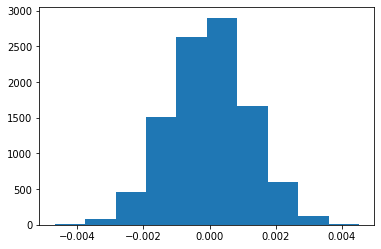

In [32]:
# Looping achieves correct results, but is much slower than using built in numpy methods
pdiffs = []
for _ in range(10000):
    new_page_converted = np.random.choice(2,nnew,p=[1-pnew,pnew]).mean()
    old_page_converted = np.random.choice(2,nold,p=[1-pold,pold]).mean()
    pdiffs.append(new_page_converted-old_page_converted)
    
std_d_pdiffs = np.std(pdiffs)

plt.hist(pdiffs);

In [48]:
#Using an inbuilt numpy method to simulate this trial is much quicker

new_page_converted = np.random.binomial(nnew,pnew,10000)/nnew
old_page_converted = np.random.binomial(nold,pold,10000)/nold

conv_diff = new_page_converted - old_page_converted
std_d_conv_diff = np.std(conv_diff)
mean = np.mean(conv_diff)

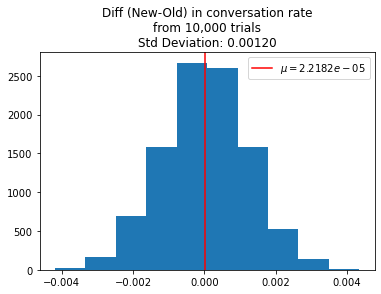

In [50]:
plt.hist(conv_diff)
plt.axvline(mean,label='$\mu = {:.5}$'.format(mean),color='red')
plt.title('Diff (New-Old) in conversation rate\n\
from 10,000 trials\nStd Deviation: {:.5f}'.format(std_d_conv_diff))
plt.legend(loc='best');

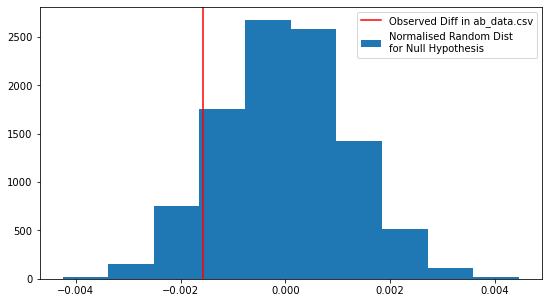

In [53]:
# Step 3 - Generate a norandom distribution centred on zero. Standard deviation equal to the bootstrap standard deviation above
null_vals = np.random.normal(0,std_d_conv_diff,10000)
plt.figure(figsize=(9,5))
plt.axvline(diff,color='red',label='Observed Diff in ab_data.csv')
# Step 4 - Plot the observed value against the distribution plot of the null hypothesis.
plt.hist(null_vals,label = 'Normalised Random Dist\n\
for Null Hypothesis')
plt.legend(loc='best');

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [54]:
(null_vals > diff).mean()

0.8993

The value calculated above is the p value or confidence interval. It is the probabily of which the observation came from this particular distribution and in this case the Null Hypothesis.

This result would suggest that there is only a **10%** likelihood of this observation came from this distribution. However, since our Null Hypothesis is:

$ H_{0}: p_{new} - p_{old} \leq 0$

This result provides insufficient evidence to reject our Null Hypothesis. The evidence suggests that the old page performed better or atleast as good as the new page. This is evident from the above plot which shows that on average the new page performed slightly worse that the old page.

**Some explanation on the alternative hypothesis**

Our alternative hypothesis was to prove that the new page produced a higher conversion rate. We wanted to demonstrate this with a confince of a Type I error rate of 5%. For this to have been the case our finding would have had to be greater than the 97.5% confidence interval on the null hypothesis plot above. In that case we would have said that the results suggest that the observation didn't come from the null hypothesis and rejected the null.

**Some notes on statistical significance**
Although we didn't find sufficient evidence to reject the null hypothesis. If the results observed were in favour of the Alternative hypothesis, the results would have been practically insignificant because the observed difference in conversion rate was so small (in the region of 0.2%). Such a small difference in conversion rate would not be a reasonable justification for changing a web page.

We could also use a built-in to achieve similar results. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

Null Hypothesis 

$ H_{0}: p_{new} - p_{old} \leq 0$

Alternative Hypothesis

$ H_{1}: p_{new} - p_{old} > 0$

In [55]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

convert_old = df2[(df2['landing_page']=='old_page') & (df2['converted']==1)].shape[0]
convert_new = df2[(df2['landing_page']=='new_page') & (df2['converted']==1)].shape[0]
n_old = df2[df2['landing_page']=='old_page'].shape[0]
n_new = df2[df2['landing_page']=='new_page'].shape[0]

Now use `stats.proportions_ztest` to compute your test statistic and p-value.  

Reference to link used: [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/)

In [56]:
count = np.array([convert_new,convert_old])
nobs = np.array([n_new,n_old])
stat, pval = proportions_ztest(count,nobs,alternative='larger')

In [57]:
stat

-1.3109241984234394

In [58]:
pval

0.9050583127590245

Using statsmodel proportionas ztest it is also clear that there is insufficient evidence to reject the null hypothesis.

The results show that the new page produced slightly less of a conversion rate, thus the negative statistic. That is is **Z-score of -1.31**. The **P-value of 0.905** also demonstrates that there is very little likelihood that the new page would generate a higher conversion rate. This P-value shows that this result is unlikely to have come from a distribution where the conversion rate of the old and new are equal. It provides evidence that in fact the new page performs worse than the new. This is convered by the Null Hypothesis:

$ H_{0}: p_{new} - p_{old} \leq 0$


<a id='regression'></a>
### Part III - A regression approach

In this final part, we shall perform a regression analysis to see if the same outcome would have been arrived at.<br><br>

The goal is to use **statsmodels** to fit the regression model to the conversion data to see if there is a significant difference in conversion based on which page a customer receives.

In [59]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [60]:
#Create the intercept
df2['intercept']=1

#Add in dummy variables for group/page
df2[['ab_page','control']]=pd.get_dummies(df['group'])

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,control
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,0


Use **statsmodels** to import regression model.  Instantiate the model, and fit the model to predict whether or not an individual converts.

In [61]:
model = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = model.fit();

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [62]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        13:32:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
ab_page        0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

The p-value associated with the ab_page is **0.19**. This is approximately double what we observed in part II. The Null hypothesis in part II was a one sided test. We were trying to show that the conversion rate of the original page was greater than or equal to the conversion rate of the new page. 

However, in this regression approach we are simply asking if they are equal so we are evaluating the results of both tails of the curve leading to p-value which was twice as large. There is less certainty of predicting the correct outcome, rather than simply predicting whether the new page will perform the same or worse than the original.

At present, the only feature we have in our model to predict the conversion is the page which the candidates were given. This feature has proven to be fairly inconsequential at predicting conversion. In order to improve our prediction capabilities we should look for additional features which enable us to predict with a higher accuracy.

When selecting additional features we should evaluate them on a one by one basis to ensure we are including valuable features into the model. We should also be hesitant of including to many features. Each feature will add additional complexity to the model and increase our data requirements. We need to ensure that this trade off is worth the additional benefit obtained in prediction accuracy.

We should also perform checks on additional features to verify the dependancy between those exisitng features. Checks could include co-linearity etc.

We will now combined country data associated with the users to see if that is a valuable piece of data used to predict conversion rate.

In [63]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [64]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [65]:
df_new[['US','UK','CA']] = pd.get_dummies(df_new['country'])

In [66]:
df_new

,country,timestamp,group,landing_page,converted,intercept,ab_page,control,US,UK,CA
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,1,0,0,0,1
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,1,0,0,1,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,1,0,0,1,0


**Review country effects only on conversion rate prediction**

In [74]:
#Drop one column
ml = sm.Logit(df_new['converted'],df_new[['intercept','US','UK']])
results = ml.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:               1.521e-05
Time:                        13:40:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
US            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [75]:
# Compare results to scikit learn Logistic Regression Model
#Split up response and independant variables
y = df_new['converted']
X = df_new[['US','UK']]

#Split Data into Test and Train Data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#Create Model
md2 = LogisticRegression()
md2.fit(X_train,y_train)
y_pred = md2.predict(X_test)
accuracy_score(y_test,y_pred)

0.8797597948965019

**Review combined impact of page and country**

In [76]:
ml = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','US','UK']])
results = ml.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:               2.323e-05
Time:                        13:40:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0042      0.009   -224.560      0.000      -2.022      -1.987
ab_page        0.0149      0.011      1.307      0.191      -0.007       0.037
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [77]:
# Compare results to scikit learn Logistic Regression Model

In [78]:
#Split up response and independant variables
y = df_new['converted']
X = df_new[['ab_page','US','UK']]

#Split Data into Test and Train Data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#Create Model
md2 = LogisticRegression()
md2.fit(X_train,y_train)
y_pred = md2.predict(X_test)

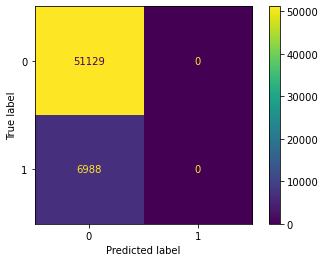

In [79]:
plot_confusion_matrix(md2,X_test,y_test);

In [80]:
accuracy_score(y_test,y_pred)

0.8797597948965019

Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [81]:
df_new

,country,timestamp,group,landing_page,converted,intercept,ab_page,control,US,UK,CA
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,1,0,0,0,1
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,1,0,0,1,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,1,0,0,1,0


In [82]:
# We will now look at the interaction between country and page.
# This will be achieved by mutiplying the encoded values of country and page to form ne columns
df_new['US_ab_page']= df_new['ab_page'] * df_new['US']
df_new['UK_ab_page']= df_new['ab_page'] * df_new['UK']

In [83]:
ml = sm.Logit(df_new['converted'],df_new[['intercept','US_ab_page','UK_ab_page']])
results = ml.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366121
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:               5.227e-07
Time:                        13:41:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.9459
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9966      0.006   -321.964      0.000      -2.009      -1.984
US_ab_page    -0.0074      0.037     -0.200      0.842      -0.080       0.065
UK_ab_page     0.0044      0.017      0.254      0.799      -0.029       0.038
==============================================================================
"""

In [84]:
# Compare results to scikit learn Logistic Regression Model
#Split up response and independant variables
y = df_new['converted']
X = df_new[['US_ab_page','UK_ab_page']]

#Split Data into Test and Train Data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#Create Model
md2 = LogisticRegression()
md2.fit(X_train,y_train)
y_pred = md2.predict(X_test)
accuracy_score(y_test,y_pred)

0.8797597948965019

<a id='conclusions'></a>
## Conclusions

The A/B Testing conducted on the new and old page of the e-commerce website to evaluate conversion rate provided insufficient evidence to reject our Null Hypothesis. 

The evidence suggests that the old page performed better or atleast as good as the new page. There is no justification in terms of customer conversion rate from changing the web design. Conversion rate in this example was deemed the most important business metric by which to measure value back to the business. 

Conversion rate alone may not always be the best metric to evaluate a change on. If a business wants to evaluate the performance of a new feature in relation to an existing one, there should be some real careful consideration into what metric is best to conduct the evaluation on. This should link back to what the central business model and strategy is.

In some further analysis, we looked at regression model for predicting conversion rate. This had limited success, partly because we don't have many features on which to base the conversion rate on and the impact of the web page appeared to be close to null.

It is evident that inclusion of country has little impact on accuracy of the model in predicting conversion. This remains the case when we determine the interaction between coutnry and page.

In order to better predict the conversion rate, additional research would be required to obtain new features.